# Data Preprocessing, Model Training, and Validation
This notebook covers loading the dataset, preprocessing, training the handwriting generation model, and validating its performance.

In [1]:
# Import required libraries
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from model import HandwritingGenerator
import matplotlib.pyplot as plt
import os

## 1. Load and Explore the Dataset
We will load the training and validation datasets from the `data` directory and inspect their structure.

In [2]:
# Load datasets
# Updated: allow_pickle=True to support object arrays
data_dir = 'data'
train_data = np.load(os.path.join(data_dir, 'deepwriting_training.npz'), allow_pickle=True)
val_data = np.load(os.path.join(data_dir, 'deepwriting_validation.npz'), allow_pickle=True)

print("Training keys:", train_data.files)
print("Validation keys:", val_data.files)

Training keys: ['subject_labels', 'eoc_labels', 'alphabet', 'strokes', 'eow_labels', 'char_labels', 'word_labels', 'max', 'min', 'soc_labels', 'mean', 'texts', 'std', 'preprocessing', 'sow_labels']
Validation keys: ['subject_labels', 'eoc_labels', 'alphabet', 'strokes', 'eow_labels', 'char_labels', 'word_labels', 'max', 'min', 'soc_labels', 'mean', 'texts', 'std', 'preprocessing', 'sow_labels']


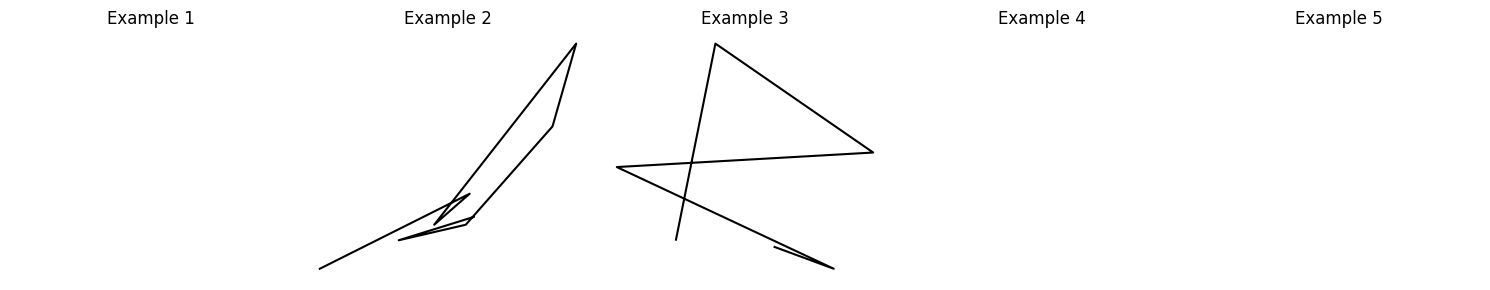

In [3]:
# Visualize a few examples of training strokes
num_examples = 5
fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
for i in range(num_examples):
    stroke = train_data['strokes'][i]
    # Assume stroke shape is (T, 3): [x, y, pen_state]
    x = stroke[:, 0]
    y = stroke[:, 1]
    pen_state = stroke[:, 2]
    # Only plot points where pen is down (pen_state == 1)
    axes[i].plot(x[pen_state == 1], y[pen_state == 1], 'k-')
    axes[i].set_title(f'Example {i+1}')
    axes[i].invert_yaxis()
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## 2. Preprocess the Data
Prepare the data for model training by normalizing and formatting as sequences.

In [4]:
# Example preprocessing (customize as needed based on dataset structure)
def preprocess(data):
    # Assume data['strokes'] contains sequences of pen movements
    strokes = data['strokes']
    # Normalize strokes
    strokes = (strokes - np.mean(strokes)) / np.std(strokes)
    return strokes

train_strokes = preprocess(train_data)
val_strokes = preprocess(val_data)

ValueError: operands could not be broadcast together with shapes (326,3) (319,3) 

## 3. Create PyTorch Dataset and DataLoader
Wrap the data in a Dataset class for batching and shuffling.

In [ ]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes):
        self.strokes = strokes
    def __len__(self):
        return len(self.strokes)
    def __getitem__(self, idx):
        # Return input and target sequences
        seq = self.strokes[idx]
        return torch.tensor(seq[:-1], dtype=torch.float32), torch.tensor(seq[1:], dtype=torch.float32)

batch_size = 64
train_dataset = HandwritingDataset(train_strokes)
val_dataset = HandwritingDataset(val_strokes)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## 4. Initialize Model, Loss, and Optimizer
Set up the model, loss function, and optimizer for training.

In [ ]:
input_size = train_strokes.shape[2]  # e.g., (N, T, 3) for (x, y, pen_state)
hidden_size = 256
num_layers = 2
output_size = input_size

model = HandwritingGenerator(input_size, hidden_size, num_layers, output_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 5. Train the Model
Train the model and monitor training and validation loss.

In [ ]:
epochs = 20
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        optimizer.zero_grad()
        output, _ = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            output, _ = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

## 6. Visualize Training and Validation Loss

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## 7. Save the Trained Model

In [ ]:
torch.save(model.state_dict(), 'output/handwriting_model.pth')
print("Model saved to output/handwriting_model.pth")